In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os 
from pprint import pprint

In [3]:
import csv 

In [4]:
import numpy as np
import decimal
import copy

In [5]:
import matplotlib
import matplotlib.pyplot as plt

In [6]:
import time

Set wait time to check if calculation has finished

In [7]:
status_refresh = 1

In [8]:
import streamm

In this getting started example we will calculate the coupling between P3HT oligomers

In [9]:
import logging
logging.basicConfig(filename='p3ht_et.log',level=logging.DEBUG)

And a resource object to keep track of where our files are 

In [10]:
res_local = streamm.Resource('local')

Update relative location of templates directory 

In [11]:
res_local.dir['templates'] =  os.path.join(res_local.dir['home'],'..','templates','')

In [12]:
res_local.make_dir()

Now we need to set a remote resource we have ssh access to and run calculations 

In [13]:
peregrine = streamm.Resource('peregrine')

In [14]:
peregrine.meta['type'] = "ssh"
peregrine.ssh['username'] = "tkemper"    
peregrine.ssh['address'] = "peregrine.hpc.nrel.gov"    
peregrine.dir['storage'] = '/mss/users/%s'%(peregrine.ssh['username'])
peregrine.dir['scratch'] = '/scratch/%s'%(peregrine.ssh['username'])
peregrine.dir['home'] = res_local.dir['home']
peregrine.dir['launch'] = res_local.dir['launch']
peregrine.dir['templates'] = res_local.dir['templates']

# Set default simulation specs
peregrine.properties['allocation'] = 'orgopv'
peregrine.properties['e-mail'] = 'travis.kemper@nrel.gov'
peregrine.properties['scratch'] = peregrine.dir['scratch']
peregrine.properties['allocation'] = 'orgopv'
peregrine.properties['walltime'] = 4
peregrine.properties['nodes'] = int(1)
peregrine.properties['ppn'] = int(24)
peregrine.properties['nproc'] = peregrine.properties['nodes']*peregrine.properties['ppn']
peregrine.properties['queue'] = 'short'
peregrine.properties['feature'] = '24core'
peregrine.properties['exe_command'] = 'qsub '

In [15]:
pprint(peregrine.properties)

{u'allocation': 'orgopv',
 'e-mail': 'travis.kemper@nrel.gov',
 u'exe_command': 'qsub ',
 u'feature': '24core',
 u'nodes': 1,
 u'nproc': 24,
 u'pmem': 1500,
 u'ppn': 24,
 u'queue': 'short',
 'scratch': '/scratch/tkemper',
 u'walltime': 4}


In [16]:
peregrine.make_dir()

Now let's create project and resource to keep track of our work

In [17]:
p3ht_et = streamm.Project('P3HT_ET')

In [18]:
p3ht_et.set_resource(res_local)

Explicitely create a thiophene molecule

In [19]:
bbTh = streamm.Buildingblock('thiophene')
symbols = ['C','C','C','C','S','H','H','H','H']
positions = [ ]
positions.append([-1.55498576,-1.91131218,-0.00081000])
positions.append([-0.17775976,-1.91131218,-0.00081000])
positions.append([0.34761524,-0.57904218,-0.00081000])
positions.append([-0.65884476,0.36101082,0.00000000])
positions.append([-2.16948076,-0.35614618,-0.00000800])
positions.append([-2.18966076,-2.79526518,-0.00132100])
positions.append([0.45389024,-2.80145418,-0.00106400])
positions.append([1.41682424,-0.35961818,-0.00138200])
positions.append([-0.51943676,1.44024682,0.00064700])
for i in range(len(symbols)):
    pt_i = streamm.Particle(symbol=symbols[i])
    pos_i = positions[i]
    bbTh.add_partpos(pt_i,pos_i)

In [20]:
bbTh.particles[5].rsite = 'termcap'
bbTh.particles[6].rsite = 'funccap'
bbTh.particles[8].rsite = 'termcap'

Set some properties of the molecule to keep track of the parts

In [21]:
c_cnt =1
h_cnt =1

for pkey_i, particle_i  in bbTh.particles.iteritems():

    if( particle_i.symbol == 'C' ):
        particle_i.label = "C%d"%(c_cnt)
        particle_i.resname = "SCP2"
        particle_i.residue = 1

        c_cnt +=1 
    if( particle_i.symbol == 'S' ):
        particle_i.resname = "ThS"
        particle_i.residue = 2

    if( particle_i.symbol == 'H' ):
        particle_i.label = "H%d"%(h_cnt)
        particle_i.resname = "HA"
        particle_i.residue = 3

        h_cnt +=1 


Set the force-field type and guess some reasonable charges 

In [22]:
for pkey_i, particle_i  in bbTh.particles.iteritems():
    if( particle_i.symbol == 'C' ):
        particle_i.paramkey = 'CA'
        particle_i.charge = -0.025
    if( particle_i.symbol == 'S' ):
        particle_i.paramkey = 'S'
        particle_i.charge = -0.3
    if( particle_i.symbol == 'H' ):
        particle_i.paramkey = 'HA'
        particle_i.charge = 0.1

Check molecule is neutral 

In [23]:
total_charge = 0.0
for pkey_i, particle_i  in bbTh.particles.iteritems():
    total_charge += particle_i.charge
print total_charge

-2.77555756156e-17


Optimize structure with NWChem

But let's put it in a function this time

In [24]:
def nw_opt(project_i,bb_i,res_i):
    '''Optimize a streamm Buildingblock object with nwchem 
    
    '''
    calc_n =  len(project_i.calculations)     
    nwchem_i = streamm.NWChem('nw_opt_{}_calc_{}'.format(bb_i.tag,calc_n))
    print nwchem_i.tag 
    # Add thiophene structure 
    nwchem_i.strucC = copy.deepcopy(bb_i)
    # Set calculation to run on external resource
    nwchem_i.set_resource(res_i)
    # Make the local directories 
    nwchem_i.make_dir()
    #Change to the `launch` directory
    os.chdir(nwchem_i.dir['launch'])
    # Copy over templates
    nwchem_i.cp_file('templates','run',"nwchem_peregrine.pbs",'templates','launch')
    nwchem_i.cp_file('templates','nw',"nwchem.nw",'templates','launch')
    # Read in templates files 
    nwchem_i.load_str('templates','nw')        
    nwchem_i.load_str('templates','run')
    # Set calculation properties 
    nwchem_i.properties['basis'] = '6-31g'
    nwchem_i.properties['method'] = 'UHF'
    nwchem_i.properties['charge'] = 0
    nwchem_i.properties['spin_mult'] = 1
    nwchem_i.properties['task'] = 'SCF optimize'
    nwchem_i.properties['coord'] = nwchem_i.strucC.write_coord()
    # 
    pprint(nwchem_i.properties)
    # Replace <key> with properties value 
    nwchem_i.replacewrite_prop('nw','input','nw','%s.nw'%(nwchem_i.tag))
    nwchem_i.properties['input_nw'] = nwchem_i.files['input']['nw']
    nwchem_i.replacewrite_prop('run','scripts','run','%s.pbs'%(nwchem_i.tag))
    #
    nwchem_i.add_file('output','log',"%s.log"%(nwchem_i.tag))
    # Save details in .json files 
    os.chdir(nwchem_i.dir['home'])
    p3ht_et.export_json()
    # 
    os.chdir(nwchem_i.dir['launch'])
    # 
    nwchem_i.push()
    # 
    nwchem_i.run()
    # Add calculation to project
    project_i.add_calc(nwchem_i,deepcopy = True)
    # 
    return project_i 

In [25]:
p3ht_et = nw_opt(p3ht_et,bbTh,peregrine)

nw_opt_thiophene_calc_0
{u'allocation': 'orgopv',
 u'basis': '6-31g',
 u'charge': 0,
 'comp_key': 'compressed',
 'compress': 'tar -czf ',
 'compress_sufix': 'tgz',
 'coord': u'     C      -1.55498576      -1.91131218      -0.00081000 \n     C      -0.17775976      -1.91131218      -0.00081000 \n     C       0.34761524      -0.57904218      -0.00081000 \n     C      -0.65884476       0.36101082       0.00000000 \n     S      -2.16948076      -0.35614618      -0.00000800 \n     H      -2.18966076      -2.79526518      -0.00132100 \n     H       0.45389024      -2.80145418      -0.00106400 \n     H       1.41682424      -0.35961818      -0.00138200 \n     H      -0.51943676       1.44024682       0.00064700 \n',
 'e-mail': 'travis.kemper@nrel.gov',
 u'exe_command': 'qsub ',
 u'feature': '24core',
 u'finish_str': u'Total times  cpu:',
 u'maxiter': 100,
 u'method': 'UHF',
 u'nodes': 1,
 u'nproc': 24,
 u'pmem': 1500,
 u'ppn': 24,
 u'queue': 'short',
 'scratch': '/scratch/tkemper/nw_opt_thiop

In [26]:
nwchem_i = p3ht_et.calculations['nw_opt_thiophene_calc_0']

Check status unit finished

In [27]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(status_refresh)    

In [28]:
print nwchem_i.meta['status']

finished


In [29]:
nwchem_i.analysis()

Print energies 

In [30]:
print nwchem_i.properties['energy'],nwchem_i.unit_conf['energy']

-551.190757873 Ha


Check that the positions of the structure have been optimized 

In [31]:
print bbTh.positions

[[ -1.55498576e+00  -1.91131218e+00  -8.10000000e-04]
 [ -1.77759760e-01  -1.91131218e+00  -8.10000000e-04]
 [  3.47615240e-01  -5.79042180e-01  -8.10000000e-04]
 [ -6.58844760e-01   3.61010820e-01   0.00000000e+00]
 [ -2.16948076e+00  -3.56146180e-01  -8.00000000e-06]
 [ -2.18966076e+00  -2.79526518e+00  -1.32100000e-03]
 [  4.53890240e-01  -2.80145418e+00  -1.06400000e-03]
 [  1.41682424e+00  -3.59618180e-01  -1.38200000e-03]
 [ -5.19436760e-01   1.44024682e+00   6.47000000e-04]]


In [32]:
bbTh.unit_conf['length']

u'ang'

In [33]:
print nwchem_i.strucC.positions

[[ -1.52907004e+00  -1.96233843e+00  -1.23341000e-03]
 [ -1.87273370e-01  -1.91412987e+00  -1.73523000e-03]
 [  3.42609150e-01  -5.70398020e-01  -1.25113000e-03]
 [ -6.05157220e-01   3.80544790e-01  -3.32630000e-04]
 [ -2.25060124e+00  -3.24219650e-01  -2.63810000e-04]
 [ -2.16239570e+00  -2.82036259e+00  -8.80000000e-05]
 [  4.31314900e-01  -2.78795308e+00  -1.22182000e-03]
 [  1.39124929e+00  -3.53851760e-01  -4.46300000e-04]
 [ -4.82514600e-01   1.43981597e+00   1.01435000e-03]]


In [34]:
nwchem_i.strucC.unit_conf['length']

u'ang'

Update positions with optimized geometry 

In [35]:
for pk,p in bbTh.particles.iteritems():
    bbTh.positions[pk] = nwchem_i.strucC.positions[pk]
    print pk,p.symbol,bbTh.positions[pk]

0 C [ -1.52907004e+00  -1.96233843e+00  -1.23341000e-03]
1 C [ -1.87273370e-01  -1.91412987e+00  -1.73523000e-03]
2 C [ 0.34260915 -0.57039802 -0.00125113]
3 C [ -6.05157220e-01   3.80544790e-01  -3.32630000e-04]
4 S [ -2.25060124e+00  -3.24219650e-01  -2.63810000e-04]
5 H [ -2.16239570e+00  -2.82036259e+00  -8.80000000e-05]
6 H [  4.31314900e-01  -2.78795308e+00  -1.22182000e-03]
7 H [  1.39124929e+00  -3.53851760e-01  -4.46300000e-04]
8 H [ -4.82514600e-01   1.43981597e+00   1.01435000e-03]


Store the results in a tar ball in the storage directory 

In [36]:
nwchem_i.store()

Now let us calculate the ESP charges to use in our forcefield 

Again let's make it a function

In [37]:
def nw_esp(project_i,bb_i,res_i):
    '''Calculate ESP charges of a streamm Buildingblock object with nwchem 
    
    '''
    calc_n =  len(project_i.calculations)     
    nwchem_esp = streamm.NWChem('nw_esp_{}_calc_{}'.format(bb_i.tag,calc_n))
    print(nwchem_esp.tag)
    # Add thiophene structure with optimized coordinates from previous calculation
    nwchem_esp.strucC = copy.deepcopy(bb_i)
    # Set calculation to run on external resource
    nwchem_esp.set_resource(res_i)
    # Add calculation to project
    project_i.add_calc(nwchem_esp)
    # Make the local directories 
    nwchem_esp.make_dir()
    # Change to the `launch` directory
    os.chdir(nwchem_esp.dir['launch'])
    #
    nwchem_esp.cp_file('templates','run',"nwchem_peregrine.pbs",'templates','launch')
    nwchem_esp.cp_file('templates','nw',"nwchem_esp.nw",'templates','launch')
    #
    nwchem_esp.load_str('templates','nw')        
    nwchem_esp.load_str('templates','run')
    # 
    nwchem_esp.properties['basis'] = '6-31g'
    nwchem_esp.properties['method'] = 'UHF'
    nwchem_esp.properties['charge'] = 0
    nwchem_esp.properties['spin_mult'] = 1
    nwchem_esp.properties['task'] = 'SCF'
    nwchem_esp.properties['coord'] = nwchem_esp.strucC.write_coord()

    pprint(nwchem_esp.properties)

    nwchem_esp.replacewrite_prop('nw','input','nw','%s.nw'%(nwchem_esp.tag))

    nwchem_esp.properties['input_nw'] = nwchem_esp.files['input']['nw']
    nwchem_esp.replacewrite_prop('run','scripts','run','%s.pbs'%(nwchem_esp.tag))

    nwchem_esp.add_file('output','log',"%s.log"%(nwchem_esp.tag))

    # Save details in .json files 

    os.chdir(nwchem_esp.dir['home'])
    nwchem_esp.export_json()

    os.chdir(nwchem_esp.dir['launch'])
    nwchem_esp.push()
    nwchem_esp.run()
    # Add calculation to project
    project_i.add_calc(nwchem_esp,deepcopy = True)
    # 
    return project_i 
    
    

In [38]:
p3ht_et = nw_esp(p3ht_et,bbTh,peregrine)

nw_esp_thiophene_calc_1
{u'allocation': 'orgopv',
 u'basis': '6-31g',
 u'charge': 0,
 'comp_key': 'compressed',
 'compress': 'tar -czf ',
 'compress_sufix': 'tgz',
 'coord': u'     C      -1.52907004      -1.96233843      -0.00123341 \n     C      -0.18727337      -1.91412987      -0.00173523 \n     C       0.34260915      -0.57039802      -0.00125113 \n     C      -0.60515722       0.38054479      -0.00033263 \n     S      -2.25060124      -0.32421965      -0.00026381 \n     H      -2.16239570      -2.82036259      -0.00008800 \n     H       0.43131490      -2.78795308      -0.00122182 \n     H       1.39124929      -0.35385176      -0.00044630 \n     H      -0.48251460       1.43981597       0.00101435 \n',
 'e-mail': 'travis.kemper@nrel.gov',
 u'exe_command': 'qsub ',
 u'feature': '24core',
 u'finish_str': u'Total times  cpu:',
 u'maxiter': 100,
 u'method': 'UHF',
 u'nodes': 1,
 u'nproc': 24,
 u'pmem': 1500,
 u'ppn': 24,
 u'queue': 'short',
 'scratch': '/scratch/tkemper/nw_esp_thiop

Check status until finished

In [39]:
nwchem_i = p3ht_et.calculations['nw_esp_thiophene_calc_1']

In [40]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(status_refresh)    

In [41]:
p3ht_et.check()

Calculation nw_esp_thiophene_calc_1 has status finished
Calculation nw_opt_thiophene_calc_0 has status stored


In [42]:
nwchem_i.analysis()

In [45]:
total_charge = 0.0 
for pk,p in nwchem_i.strucC.particles.iteritems():
    print pk,p.symbol,p.charge
    total_charge += p.charge
print total_charge

0 C -0.0857
1 C -0.1369
2 C -0.0858
3 C -0.1088
4 S -0.1178
5 H 0.1538
6 H 0.119
7 H 0.1091
8 H 0.153
-0.0001


Hum a little extra charge can cause problems with our MD simulation so let's round and set to neutral 

In [50]:
total_charge = 0.0 
for pk,p in nwchem_i.strucC.particles.iteritems():
    p.charge = round(p.charge,4)
    total_charge += p.charge
print total_charge
for pk,p in nwchem_i.strucC.particles.iteritems():
    p.charge += -1.0*total_charge/nwchem_i.strucC.n_particles 
nwchem_i.strucC.calc_charge()
print nwchem_i.strucC.charge



-0.0001
2.77555756156e-17


Update the charges of the Buildingblock

In [51]:
bbTh.tag += '_HFesp'

In [52]:
for pk,p in bbTh.particles.iteritems():
    p.charge = nwchem_i.strucC.particles[pk].charge
    print pk,p.symbol,p.charge

0 C -0.0856888888889
1 C -0.136888888889
2 C -0.0857888888889
3 C -0.108788888889
4 S -0.117788888889
5 H 0.153811111111
6 H 0.119011111111
7 H 0.109111111111
8 H 0.153011111111


Store the results 

In [53]:
nwchem_i.store()

In [54]:
bbTh.bonded_nblist = bbTh.guess_nblist(0,radii_buffer=1.35)

In [55]:
bbTh.bonded_bonds()
bbTh.bonded_angles()
bbTh.bonded_dih()

Store a object of the Buildingblock

In [294]:
os.chdir(res_local.dir['materials']) 
th_json = bbTh.export_json()

Let us optimize the structure with the oplsaa force-field to check the parameters 

In [57]:
os.chdir(res_local.dir['home']) 

In [58]:
from pathlib2 import Path

In [59]:
need_files = ['oplsaa_param.json']
for f in need_files:
    path = Path(f)
    if not path.is_file():
        print("Need to run forcefields.ipynb")
        os.system("jupyter nbconvert --to python  forcefields.ipynb")
        os.system("python forcefields.py")

In [60]:
oplsaa = streamm.Parameters('oplsaa')

In [61]:
oplsaa.import_json(read_file=True)

In [62]:
print oplsaa


    Parameters 
      LJ parameters 2 
      Bond parameters 2 
      Angle parameters 2 
      Dihedral parameters 1 
      Improper Dihedral parameters 0 



In [63]:
print oplsaa.unit_conf['energy']

kCalmol


We need to add the conjugated carbons, hydrogen and sulfur atom types 

In [64]:
import streamm.forcefields.particletype as particletype

In [65]:
import pymatgen_core.core.periodic_table as periodic_table

Set some parameters from J. Am. Chem. Soc., 1996, 118 (45), pp 11225–11236

In [66]:
CA = particletype.Particletype('CA')
HA = particletype.Particletype('HA')

In [67]:
CA.update_units(oplsaa.unit_conf)
HA.update_units(oplsaa.unit_conf)

In [68]:
CA.epsilon = 0.070 # kcal/mol
CA.sigma = 3.55 # Angstroms 

In [69]:
HA.epsilon = 0.030 # kcal/mol
HA.sigma = 2.42 # Angstroms 

In [70]:
CA.mass =  periodic_table.Element['C'].atomic_mass.real
HA.mass =  periodic_table.Element['H'].atomic_mass.real

In [71]:
print CA,HA

 CA epsilon:0.07 sigma:3.55  HA epsilon:0.03 sigma:2.42


In [72]:
S = particletype.Particletype('S')

In [73]:
S.update_units(oplsaa.unit_conf)

Set some parameters from J. Am. Chem. Soc., 1996, 118 (45), pp 11225–11236

In [74]:
S.epsilon = 0.25 # kcal/mol
S.sigma = 3.55 # Angstroms 

In [75]:
S.mass =  periodic_table.Element['S'].atomic_mass.real

Add to forcefield parameters container

In [76]:
oplsaa.add_particletype(CA)
oplsaa.add_particletype(HA)
oplsaa.add_particletype(S)

Set the bond stretching parameters 

In [77]:
import streamm.forcefields.bondtype as bondtype

In [78]:
bt_i = bondtype.Bondtype('CA','HA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.080,367.0)
oplsaa.add_bondtype(bt_i)

In [79]:
bt_i = bondtype.Bondtype('CA','CA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.400,469.0)
oplsaa.add_bondtype(bt_i)

In [80]:
bt_i = bondtype.Bondtype('S','CA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.71,250.0)
oplsaa.add_bondtype(bt_i)

In [81]:
for btk,bt in oplsaa.bondtypes.iteritems():
    print btk,bt

0  bond  CT - HC type harmonic 
  harmonic r_0 = 1.080000 K = 367.000000 lammps index 0  gromacs index 0  
1  bond  CT - CT type harmonic 
  harmonic r_0 = 1.530000 K = 268.000000 lammps index 0  gromacs index 0  
2  bond  CA - HA type harmonic 
  harmonic r_0 = 1.080000 K = 367.000000 lammps index 0  gromacs index 0  
3  bond  CA - CA type harmonic 
  harmonic r_0 = 1.400000 K = 469.000000 lammps index 0  gromacs index 0  
4  bond  S - CA type harmonic 
  harmonic r_0 = 1.710000 K = 250.000000 lammps index 0  gromacs index 0  


In [82]:
import streamm.forcefields.angletype as angletype

In [83]:
bat_i = angletype.Angletype('CA','CA','CA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,63.0)
oplsaa.add_angletype(bat_i)

In [84]:
bat_i = angletype.Angletype('CA','CA','HA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,35.0)
oplsaa.add_angletype(bat_i)

In [85]:
bat_i = angletype.Angletype('CA','S','CA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(92.2,70.0)
oplsaa.add_angletype(bat_i)

In [86]:
bat_i = angletype.Angletype('S','CA','HA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,35.0)
oplsaa.add_angletype(bat_i)

In [87]:
bat_i = angletype.Angletype('S','CA','CA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(111.0,70.0)
oplsaa.add_angletype(bat_i)

In [88]:
for atk,at in oplsaa.angletypes.iteritems():
    print atk,at

0  angle  HC - CT - HC type harmonic 
  harmonic theta_0 = 110.700000 K = 37.500000 lammps index 0  gromacs index 0  
1  angle  HC - CT - CT type harmonic 
  harmonic theta_0 = 110.700000 K = 37.500000 lammps index 0  gromacs index 0  
2  angle  CA - CA - CA type harmonic 
  harmonic theta_0 = 120.000000 K = 63.000000 lammps index 0  gromacs index 0  
3  angle  CA - CA - HA type harmonic 
  harmonic theta_0 = 120.000000 K = 35.000000 lammps index 0  gromacs index 0  
4  angle  CA - S - CA type harmonic 
  harmonic theta_0 = 92.200000 K = 70.000000 lammps index 0  gromacs index 0  
5  angle  S - CA - HA type harmonic 
  harmonic theta_0 = 120.000000 K = 35.000000 lammps index 0  gromacs index 0  
6  angle  S - CA - CA type harmonic 
  harmonic theta_0 = 111.000000 K = 70.000000 lammps index 0  gromacs index 0  


Set some reasonable dihedral parameters

In [89]:
import streamm.forcefields.dihtype as dihtype

In [90]:
dih_i = dihtype.Dihtype('X','CA','CA','X',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,1.812532,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [91]:
dih_i = dihtype.Dihtype('X','S','CA','X',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,2.416710,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [92]:
dih_i = dihtype.Dihtype('S','CA','CA','HA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,1.812532,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [93]:
for dk,d in oplsaa.dihtypes.iteritems():
    print dk,d 

0  dihedral  HC - CT - CT - HC type opls 
  k1 = 0.000000 k2 = 0.000000 k3 = 0.300000 k4 = 0.000000 lammps index 0  gromcas index 0 
1  dihedral  X - CA - CA - X type opls 
  k1 = 0.000000 k2 = 1.812532 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
2  dihedral  X - S - CA - X type opls 
  k1 = 0.000000 k2 = 2.416710 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
3  dihedral  S - CA - CA - HA type opls 
  k1 = 0.000000 k2 = 1.812532 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 


Let us make an MD simulation of just the monomer to check that our parameters are okay

In [94]:
def lmp_run(project_i,bb_i,param_i,res_i,md_type = 'min'):
    # Create LAMMPS calculation object 
    calc_n =  len(project_i.calculations)     
    lmp_i = streamm.LAMMPS('lmp_{}_{}_calc_{}'.format(md_type,bb_i.tag,calc_n))
    # lmp_i = streamm.LAMMPS('lmp_{}_{}'.format(md_type,bb_i.tag))
    # Set parameter container 
    lmp_i.paramC = param_i
    lmp_i.set_strucC(bb_i)
    # Set force-field parameters 
    lmp_i.set_ffparam()
    # Set resource to local
    lmp_i.set_resource(res_i)
    # Make local directories
    lmp_i.make_dir()
    # Set pbc's to on
    lmp_i.strucC.lat.pbcs = [True,True,True]
    # Change to launch directory
    os.chdir(lmp_i.dir['launch'])
    # Copy over the templates from the template directory 
    lmp_i.cp_file('templates','in',"lammps_{}.in".format(md_type),'templates','launch')
    lmp_i.cp_file('templates','run',"lammps_peregrine.pbs",'templates','launch')
    # Change to scratch
    os.chdir(lmp_i.dir['launch'])
    # Read in template files and store them as strings in the `str` dictionary
    lmp_i.load_str('templates','in')
    lmp_i.load_str('templates','run')
    # Write LAMMPS .data file
    lmp_i.write_data()
    # Replace keys in template string with properties 
    lmp_i.replacewrite_prop('in','input','in','%s.in'%(lmp_i.tag))
    # Add the input file to the properties to be written into the run file
    lmp_i.properties['input_in'] = lmp_i.files['input']['in']
    lmp_i.replacewrite_prop('run','scripts','run','%s.pbs'%(lmp_i.tag))
    # Save json file in root directory
    os.chdir(lmp_i.dir['home'])
    lmp_i.export_json()
    # Run bash script or submit to cluster
    lmp_i.add_file('output','log',"%s.log"%(lmp_i.tag))
    # Save details in .json files 
    os.chdir(lmp_i.dir['home'])
    lmp_i.export_json()
    #
    os.chdir(lmp_i.dir['launch'])
    lmp_i.push()
    lmp_i.run()
    # Add calculation to project
    project_i.add_calc(lmp_i,deepcopy = True)
    # 
    return project_i     

In [95]:
print p3ht_et.calculations.keys()

['nw_esp_thiophene_calc_1', 'nw_opt_thiophene_calc_0']


In [96]:
p3ht_et = lmp_run(p3ht_et,bbTh,oplsaa,peregrine)

In [97]:
lmp_i = p3ht_et.calculations['lmp_min_thiophene_HFesp_calc_2']

In [98]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)    

In [99]:
p3ht_et.check()

Calculation lmp_min_thiophene_HFesp_calc_2 has status finished
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation nw_opt_thiophene_calc_0 has status stored


In [100]:
lmp_i.analysis()

Energy decreased and nothing exploded so that's good

In [101]:
lmp_i.store()

Read in data file positions

In [102]:
lmp_i.pull()

Read in data file output and update positions

In [103]:
os.chdir(lmp_i.dir['launch'])

In [104]:
datafn = lmp_i.files['output']['data_1']
print datafn

min1.data


In [105]:
lmp_i.read_data_pos(datafn)

In [106]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


In [107]:
lmp_i.strucC.write_xyz()

We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [108]:
bbTh.tag += '_oplsaa'

In [109]:
for pk,p in bbTh.particles.iteritems():
    bbTh.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,bbTh.positions[pk]

0 C [ -1.56869882e+00  -1.93701954e+00  -7.62325076e-04]
1 C [ -1.72797143e-01  -1.89183578e+00  -1.04768657e-03]
2 C [ 0.33798733 -0.59682314 -0.00061482]
3 C [ -6.51129286e-01   3.89222579e-01   4.19665980e-07]
4 S [ -2.21161542e+00  -3.39334026e-01   2.79282830e-05]
5 H [ -2.16042524e+00  -2.84174945e+00  -1.09445871e-03]
6 H [  4.46226678e-01  -2.77690512e+00  -1.61473899e-03]
7 H [  1.39451741e+00  -3.72775304e-01  -7.91565071e-04]
8 H [ -4.65904499e-01   1.45432678e+00   3.39247040e-04]


Save the Buildingblock and force-field

In [291]:
os.chdir(res_local.dir['materials']) 
bbTh.write_xyz()
th_json = bbTh.export_json() 
oplsaa_json = oplsaa.export_json()

Okay now that we have a handle on thiophene let's follow the same procedure for hexane

Build hexane

In [111]:
bbHex = streamm.Buildingblock('hexane')
symbols = ['C','H','H','H','C','H','H','C','H','H','C','H','H','C','H','H','C','H','H','H']
positions = [ ]
positions.append([-6.410969,-0.381641,-0.000031])
positions.append([-7.310084,0.245311,-0.000038])
positions.append([-6.456117,-1.028799,0.884636])
positions.append([-6.456111,-1.028812,-0.884689])
positions.append([-5.135268,0.467175,-0.000033])
positions.append([-5.135484,1.128782,0.877977])
positions.append([-5.135479,1.128771,-0.87805])
positions.append([-3.850566,-0.371258,-0.000024])
positions.append([-3.85112,-1.033978,0.87841])
positions.append([-3.851114,-1.033987,-0.878451])
positions.append([-2.567451,0.469603,-0.000024])
positions.append([-2.567784,1.132155,0.8784])
positions.append([-2.567776,1.132146,-0.878455])
positions.append([-1.283527,-0.370234,-0.000013])
positions.append([-1.28337,-1.032804,0.87836])
positions.append([-1.28336,-1.032812,-0.87838])
positions.append([0.00482234,0.47342231,-0.00000898])
positions.append([0.02595107,1.09220686,0.87266464])
positions.append([0.85585781,-0.17514133,0.00194589])
positions.append([0.02780957,1.08937798,-0.87463473])
for i in range(len(symbols)):
    pt_i = streamm.Particle(symbol=symbols[i])
    pos_i = positions[i]
    bbHex.add_partpos(pt_i,pos_i)

In [112]:
bbHex.particles[0].rsite = 'rg'
bbHex.particles[1].rsite = 'rgcap'

In [113]:
c_cnt =1
h_cnt =1
for pkey_i, particle_i  in bbHex.particles.iteritems():
            if( particle_i.symbol == 'C' ):
                particle_i.label = "C%d"%(c_cnt)
                particle_i.resname = "SCP3"
                particle_i.residue = c_cnt
                c_cnt +=1 
            if( particle_i.symbol == 'H' ):
                particle_i.label = "H%d"%(h_cnt)
                particle_i.resname = "HC"
                particle_i.residue = c_cnt -1 
                h_cnt +=1 

Set the parameter keys and some reasonable atomic charges 

In [114]:
for pkey_i, particle_i  in bbHex.particles.iteritems():
            if( particle_i.symbol == 'C' ):
                particle_i.paramkey = 'CT'
                particle_i.charge = -0.12

            if( particle_i.symbol == 'H' ):
                particle_i.paramkey = 'HC'
                particle_i.charge = 0.06
            print pkey_i, particle_i.symbol,particle_i.charge

0 C -0.12
1 H 0.06
2 H 0.06
3 H 0.06
4 C -0.12
5 H 0.06
6 H 0.06
7 C -0.12
8 H 0.06
9 H 0.06
10 C -0.12
11 H 0.06
12 H 0.06
13 C -0.12
14 H 0.06
15 H 0.06
16 C -0.12
17 H 0.06
18 H 0.06
19 H 0.06


In [115]:
bbHex.particles[0].charge  = -0.18
bbHex.particles[16].charge  = -0.18

Check that the molecule is neutral 

In [116]:
bbHex.calc_charge()
print bbHex.charge


0.0


Now let us optimze and calculate ESP charges for hexane

Optimize structure with NWChem

In [117]:
print p3ht_et.calculations.keys()

['lmp_min_thiophene_HFesp_calc_2', 'nw_esp_thiophene_calc_1', 'nw_opt_thiophene_calc_0']


In [118]:
p3ht_et = nw_opt(p3ht_et,bbHex,peregrine)

nw_opt_hexane_calc_3
{u'allocation': 'orgopv',
 u'basis': '6-31g',
 u'charge': 0,
 'comp_key': 'compressed',
 'compress': 'tar -czf ',
 'compress_sufix': 'tgz',
 'coord': u'     C      -6.41096900      -0.38164100      -0.00003100 \n     H      -7.31008400       0.24531100      -0.00003800 \n     H      -6.45611700      -1.02879900       0.88463600 \n     H      -6.45611100      -1.02881200      -0.88468900 \n     C      -5.13526800       0.46717500      -0.00003300 \n     H      -5.13548400       1.12878200       0.87797700 \n     H      -5.13547900       1.12877100      -0.87805000 \n     C      -3.85056600      -0.37125800      -0.00002400 \n     H      -3.85112000      -1.03397800       0.87841000 \n     H      -3.85111400      -1.03398700      -0.87845100 \n     C      -2.56745100       0.46960300      -0.00002400 \n     H      -2.56778400       1.13215500       0.87840000 \n     H      -2.56777600       1.13214600      -0.87845500 \n     C      -1.28352700      -0.37023400      -

In [119]:
nwchem_i = p3ht_et.calculations['nw_opt_hexane_calc_3']

In [120]:
p3ht_et.check()

Calculation nw_opt_hexane_calc_3 has status finished
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation nw_opt_thiophene_calc_0 has status stored


In [121]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(status_refresh)

Get the calculation from the project object 

In [122]:
nwchem_i.analysis()

Print energies 

In [123]:
print nwchem_i.properties['alpha_energies'][10:20]
print nwchem_i.properties['energy']

[-0.5549424, -0.5282407, -0.5218841, -0.4996812, -0.4774207, -0.4626707, -0.453462, -0.4506618, -0.4351213, 0.2272358]
-235.271544412


Check that the positions of the structure have been optimized 

In [124]:
for pk,p in bbHex.particles.iteritems():
    print pk,p.symbol,bbHex.positions[pk]

0 C [ -6.41096900e+00  -3.81641000e-01  -3.10000000e-05]
1 H [ -7.31008400e+00   2.45311000e-01  -3.80000000e-05]
2 H [-6.456117 -1.028799  0.884636]
3 H [-6.456111 -1.028812 -0.884689]
4 C [ -5.13526800e+00   4.67175000e-01  -3.30000000e-05]
5 H [-5.135484  1.128782  0.877977]
6 H [-5.135479  1.128771 -0.87805 ]
7 C [ -3.85056600e+00  -3.71258000e-01  -2.40000000e-05]
8 H [-3.85112  -1.033978  0.87841 ]
9 H [-3.851114 -1.033987 -0.878451]
10 C [ -2.56745100e+00   4.69603000e-01  -2.40000000e-05]
11 H [-2.567784  1.132155  0.8784  ]
12 H [-2.567776  1.132146 -0.878455]
13 C [ -1.28352700e+00  -3.70234000e-01  -1.30000000e-05]
14 H [-1.28337  -1.032804  0.87836 ]
15 H [-1.28336  -1.032812 -0.87838 ]
16 C [  4.82234000e-03   4.73422310e-01  -8.98000000e-06]
17 H [ 0.02595107  1.09220686  0.87266464]
18 H [ 0.85585781 -0.17514133  0.00194589]
19 H [ 0.02780957  1.08937798 -0.87463473]


In [125]:
print nwchem_i.strucC.positions

[[ -6.40760238e+00  -3.78973440e-01   6.27600000e-05]
 [ -7.29442788e+00   2.45331440e-01   6.75600000e-05]
 [ -6.45208289e+00  -1.01753690e+00   8.76542800e-01]
 [ -6.45214149e+00  -1.01747508e+00  -8.76488590e-01]
 [ -5.13193100e+00   4.68066030e-01  -7.69100000e-05]
 [ -5.13100792e+00   1.11962764e+00   8.70321800e-01]
 [ -5.13115615e+00   1.11985158e+00  -8.70246750e-01]
 [ -3.85237378e+00  -3.76654640e-01  -9.18700000e-05]
 [ -3.85441471e+00  -1.02908099e+00   8.70855140e-01]
 [ -3.85460209e+00  -1.02894435e+00  -8.71215810e-01]
 [ -2.57073915e+00   4.64411170e-01  -3.89630000e-04]
 [ -2.56870076e+00   1.11690406e+00   8.70574100e-01]
 [ -2.56854074e+00   1.11654737e+00  -8.71536310e-01]
 [ -1.29151749e+00  -3.80846300e-01   1.95250000e-04]
 [ -1.29305355e+00  -1.03240824e+00   8.70521240e-01]
 [ -1.29279455e+00  -1.03288769e+00  -8.69844870e-01]
 [ -1.52670000e-02   4.65406000e-01   4.89500000e-05]
 [  2.93781600e-02   1.10472229e+00   8.75952160e-01]
 [  8.71182390e-01  -1.59488

Update positions in Buildingblock object

In [126]:
for pk,p in bbHex.particles.iteritems():
    bbHex.positions[pk] = nwchem_i.strucC.positions[pk]
    print pk,p.symbol,bbHex.positions[pk]

0 C [ -6.40760238e+00  -3.78973440e-01   6.27600000e-05]
1 H [ -7.29442788e+00   2.45331440e-01   6.75600000e-05]
2 H [-6.45208289 -1.0175369   0.8765428 ]
3 H [-6.45214149 -1.01747508 -0.87648859]
4 C [ -5.13193100e+00   4.68066030e-01  -7.69100000e-05]
5 H [-5.13100792  1.11962764  0.8703218 ]
6 H [-5.13115615  1.11985158 -0.87024675]
7 C [ -3.85237378e+00  -3.76654640e-01  -9.18700000e-05]
8 H [-3.85441471 -1.02908099  0.87085514]
9 H [-3.85460209 -1.02894435 -0.87121581]
10 C [ -2.57073915e+00   4.64411170e-01  -3.89630000e-04]
11 H [-2.56870076  1.11690406  0.8705741 ]
12 H [-2.56854074  1.11654737 -0.87153631]
13 C [ -1.29151749e+00  -3.80846300e-01   1.95250000e-04]
14 H [-1.29305355 -1.03240824  0.87052124]
15 H [-1.29279455 -1.03288769 -0.86984487]
16 C [ -1.52670000e-02   4.65406000e-01   4.89500000e-05]
17 H [ 0.02937816  1.10472229  0.87595216]
18 H [ 0.87118239 -0.15948881  0.00139176]
19 H [ 0.03065378  1.10291268 -0.87708094]


Store the results in a tar ball in the storage directory 

In [127]:
nwchem_i.store()

Now let us calculate the ESP charges to use in our forcefield 

In [128]:
p3ht_et = nw_esp(p3ht_et,bbHex,peregrine)

nw_esp_hexane_calc_4
{u'allocation': 'orgopv',
 u'basis': '6-31g',
 u'charge': 0,
 'comp_key': 'compressed',
 'compress': 'tar -czf ',
 'compress_sufix': 'tgz',
 'coord': u'     C      -6.40760238      -0.37897344       0.00006276 \n     H      -7.29442788       0.24533144       0.00006756 \n     H      -6.45208289      -1.01753690       0.87654280 \n     H      -6.45214149      -1.01747508      -0.87648859 \n     C      -5.13193100       0.46806603      -0.00007691 \n     H      -5.13100792       1.11962764       0.87032180 \n     H      -5.13115615       1.11985158      -0.87024675 \n     C      -3.85237378      -0.37665464      -0.00009187 \n     H      -3.85441471      -1.02908099       0.87085514 \n     H      -3.85460209      -1.02894435      -0.87121581 \n     C      -2.57073915       0.46441117      -0.00038963 \n     H      -2.56870076       1.11690406       0.87057410 \n     H      -2.56854074       1.11654737      -0.87153631 \n     C      -1.29151749      -0.38084630       

Check status unit finished

In [129]:
p3ht_et.check()

Calculation nw_opt_hexane_calc_3 has status stored
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation nw_opt_thiophene_calc_0 has status stored
Calculation nw_esp_hexane_calc_4 has status finished


In [130]:
nwchem_i = p3ht_et.calculations['nw_esp_hexane_calc_4']

In [131]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(status_refresh)

In [132]:
nwchem_i.analysis()

In [133]:
for pk,p in nwchem_i.strucC.particles.iteritems():
    print pk,p.symbol,p.charge

0 C -0.105262
1 H 0.014539
2 H 0.012048
3 H 0.013508
4 C 0.19358
5 H -0.055571
6 H -0.050691
7 C 0.02063
8 H -0.02177
9 H -0.023452
10 C 0.038524
11 H -0.031295
12 H -0.028867
13 C 0.205973
14 H -0.055658
15 H -0.059938
16 C -0.09414
17 H 0.006364
18 H 0.00836
19 H 0.013116


In [134]:
nwchem_i.strucC.calc_charge()
print nwchem_i.strucC.charge

-2.00000000003e-06


Hum a little extra charge can cause problems with our MD simulation so let's round and set to neutral 

In [135]:
total_charge = 0.0 
for pk,p in nwchem_i.strucC.particles.iteritems():
    p.charge = round(p.charge,4)
    total_charge += p.charge
print total_charge
for pk,p in nwchem_i.strucC.particles.iteritems():
    p.charge += -1.0*total_charge/nwchem_i.strucC.n_particles 
nwchem_i.strucC.calc_charge()
print nwchem_i.strucC.charge



-0.0002
5.37764277553e-17


Print energies 

In [136]:
print nwchem_i.properties['energy'],nwchem_i.unit_conf['energy']

-235.271544554 Ha


Update the charges of the Buildingblock

In [137]:
for pk,p in bbHex.particles.iteritems():
    p.charge = nwchem_i.strucC.particles[pk].charge

In [138]:
bbHex.tag += '_HFesp'

Store the results 

In [139]:
nwchem_i.store()

First we need to identify the bonding within the Buildingblock

In [140]:
bbHex.bonded_nblist = bbHex.guess_nblist(0,radii_buffer=1.35)

In [141]:
bbHex.bonded_bonds()
bbHex.bonded_angles()
bbHex.bonded_dih()

Add the need parameters the the oplsaa parameter container

In [142]:
bat_i = angletype.Angletype('CT','CT','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.50,40.0)
oplsaa.add_angletype(bat_i)

In [143]:
bat_i = angletype.Angletype('CT','CT','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.50,40.0)
oplsaa.add_angletype(bat_i)

In [144]:
bat_i = angletype.Angletype('CT','CT','HC',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.50,50.0)
oplsaa.add_angletype(bat_i)

In [145]:
dih_i = dihtype.Dihtype('CT','CT','CT','CT',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.433341,-0.016667,0.066668,0.0)
oplsaa.add_dihtype(dih_i)

In [146]:
dih_i = dihtype.Dihtype('HC','CT','CT','CT',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

In [147]:
dih_i = dihtype.Dihtype('HC','CT','CT','HC',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

Run a oplsaa minimization to get the minimized structure

In [148]:
p3ht_et = lmp_run(p3ht_et,bbHex,oplsaa,peregrine)

In [149]:
p3ht_et.check()

Calculation nw_opt_thiophene_calc_0 has status stored
Calculation lmp_min_hexane_HFesp_calc_5 has status finished
Calculation nw_opt_hexane_calc_3 has status stored
Calculation nw_esp_hexane_calc_4 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored


In [150]:
lmp_i = p3ht_et.calculations['lmp_min_hexane_HFesp_calc_5']

In [151]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [152]:
lmp_i.analysis()

Energy decreased and nothing exploded so that's good

In [153]:
lmp_i.store()

Read in data file positions

In [154]:
lmp_i.pull()

Read in data file output and update positions

In [155]:
print lmp_i.dir['launch']
os.chdir(lmp_i.dir['launch'])

/Users/tkemper/Development/streamm-tools/examples/scratch/lmp_min_hexane_HFesp_calc_5/


In [156]:
datafn = lmp_i.files['output']['data_1']
print datafn

min1.data


In [157]:
lmp_i.read_data_pos(datafn)

In [158]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


In [159]:
lmp_i.strucC.write_xyz()

We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [160]:
bbHex.tag += '_oplsaa'

In [161]:
for pk,p in bbHex.particles.iteritems():
    bbHex.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,bbHex.positions[pk]

0 C [ -6.34390975e+00  -3.82032191e-01  -7.30115248e-05]
1 H [ -7.21400645e+00   2.57678705e-01  -2.74034254e-05]
2 H [-6.34508723 -1.001544    0.88440987]
3 H [-6.34503522 -1.001489   -0.88445663]
4 C [ -5.08519841e+00   4.90489350e-01   1.28581641e-04]
5 H [-5.08358443  1.10747881  0.88624897]
6 H [-5.08356936  1.10771726 -0.88609911]
7 C [ -3.83780780e+00  -3.96522794e-01  -2.23011151e-04]
8 H [-3.840451   -1.01313214  0.88646776]
9 H [-3.84082341 -1.01316345 -0.88654625]
10 C [ -2.58493855e+00   4.84718355e-01  -2.49331959e-04]
11 H [-2.58165439  1.1016114   0.88590823]
12 H [-2.58156055  1.10087327 -0.88727599]
13 C [ -1.33844531e+00  -4.03380644e-01   9.48300190e-05]
14 H [-1.34091374 -1.02019563  0.88659889]
15 H [-1.34055361 -1.02076593 -0.88573817]
16 C [ -7.91000579e-02   4.68126560e-01   1.61022791e-04]
17 H [-0.07785802  1.08828311  0.88405454]
18 H [ 0.79052249 -0.17222781  0.00097209]
19 H [-0.07716419  1.08695877 -0.88479488]


Save the Buildingblock and force-field

In [295]:
os.chdir(res_local.dir['materials']) 
bbHex.write_xyz()
bbhex_json = bbHex.export_json() 
oplsaa_json = oplsaa.export_json()

In [296]:
print bbHex.tag,bbTh.tag

hexane_HFesp_oplsaa thiophene_HFesp_oplsaa


So let us make some P3HT oligomers 

In [297]:
os.chdir(res_local.dir['materials']) 

In [165]:
bbTh.find_rsites()
bbHex.find_rsites()

In [166]:
print(bbTh.show_rsites())

rsite:termcap[ paticle:atom H1 (H) index:5 n_bonds:1] 
rsite:termcap[ paticle:atom H4 (H) index:8 n_bonds:1] 
rsite:funccap[ paticle:atom H2 (H) index:6 n_bonds:1] 



In [167]:
print(bbHex.show_rsites())

rsite:rg[ paticle:atom C1 (C) index:0 n_bonds:4] 
rsite:rgcap[ paticle:atom H1 (H) index:1 n_bonds:1] 



In [168]:
import streamm.structures.buildingblock as bb

In [169]:
ht = bb.attach(bbTh,bbHex,'funccap',0,'rgcap',0,tag='3-hexyl-thiophene')

Update bond angles and dihedrals after Buildingblock join

In [170]:
ht.bonded_bonds()
ht.bonded_angles()
ht.bonded_dih()

Check that the molecule looks good

In [171]:
ht.write_xyz()

Check the charges of the removed hydrogens got summed onto the functionalized carbons correctly

In [172]:
ht.calc_charge()
ht.charge

8.153200337090993e-17

In [173]:
print(ht.show_rsites())

rsite:termcap[ paticle:atom H1 (H) index:5 n_bonds:1] 
rsite:termcap[ paticle:atom H4 (H) index:7 n_bonds:1] 
rsite:rg[ paticle:atom C1 (C) index:8 n_bonds:4] 



Add inter thiophene hexane parameters

In [174]:
bt_i = bondtype.Bondtype('CT','CA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.51,317.0)
oplsaa.add_bondtype(bt_i)

Bond angle parameters 

In [175]:
bat_i = angletype.Angletype('CA','CA','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,70.0)
oplsaa.add_angletype(bat_i)


bat_i = angletype.Angletype('HA','CA','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,35.0)
oplsaa.add_angletype(bat_i)



bat_i = angletype.Angletype('CA','CT','HC',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.5,50.0)
oplsaa.add_angletype(bat_i)

bat_i = angletype.Angletype('CA','CT','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(114.0,63.0)
oplsaa.add_angletype(bat_i)

In [176]:
for atk,at in oplsaa.angletypes.iteritems():
    print atk,at

0  angle  HC - CT - HC type harmonic 
  harmonic theta_0 = 110.700000 K = 37.500000 lammps index 0  gromacs index 0  
1  angle  HC - CT - CT type harmonic 
  harmonic theta_0 = 110.700000 K = 37.500000 lammps index 0  gromacs index 0  
2  angle  CA - CA - CA type harmonic 
  harmonic theta_0 = 120.000000 K = 63.000000 lammps index 0  gromacs index 0  
3  angle  CA - CA - HA type harmonic 
  harmonic theta_0 = 120.000000 K = 35.000000 lammps index 0  gromacs index 0  
4  angle  CA - S - CA type harmonic 
  harmonic theta_0 = 92.200000 K = 70.000000 lammps index 0  gromacs index 0  
5  angle  S - CA - HA type harmonic 
  harmonic theta_0 = 120.000000 K = 35.000000 lammps index 0  gromacs index 0  
6  angle  S - CA - CA type harmonic 
  harmonic theta_0 = 111.000000 K = 70.000000 lammps index 0  gromacs index 0  
7  angle  CT - CT - CT type harmonic 
  harmonic theta_0 = 109.500000 K = 40.000000 lammps index 0  gromacs index 0  
8  angle  CT - CT - CT type harmonic 
  harmonic theta_0 = 1

Note: The inter-ring torsional is not consider as a seperate set of parameters for the simplicity of this example

In [177]:
dih_i = dihtype.Dihtype('HC','CT','CT','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

In [178]:
dih_i = dihtype.Dihtype('CT','CT','CT','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.433341,-0.016667,0.066668,0.0)
oplsaa.add_dihtype(dih_i)

In [179]:
dih_i = dihtype.Dihtype('HC','CT','CA','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

In [180]:
dih_i = dihtype.Dihtype('CT','CT','CA','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [181]:
for dk,d in oplsaa.dihtypes.iteritems():
    print dk,d 

0  dihedral  HC - CT - CT - HC type opls 
  k1 = 0.000000 k2 = 0.000000 k3 = 0.300000 k4 = 0.000000 lammps index 0  gromcas index 0 
1  dihedral  X - CA - CA - X type opls 
  k1 = 0.000000 k2 = 1.812532 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
2  dihedral  X - S - CA - X type opls 
  k1 = 0.000000 k2 = 2.416710 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
3  dihedral  S - CA - CA - HA type opls 
  k1 = 0.000000 k2 = 1.812532 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
4  dihedral  CT - CT - CT - CT type opls 
  k1 = 0.433341 k2 = -0.016667 k3 = 0.066668 k4 = 0.000000 lammps index 0  gromcas index 0 
5  dihedral  HC - CT - CT - CT type opls 
  k1 = 0.000000 k2 = -0.000000 k3 = 0.100000 k4 = 0.000000 lammps index 0  gromcas index 0 
6  dihedral  HC - CT - CT - HC type opls 
  k1 = 0.000000 k2 = -0.000000 k3 = 0.100000 k4 = 0.000000 lammps index 0  gromcas index 0 
7  dihedral  HC - CT - CT - CA type opls 
  k1 = 0.000000 k2 = -0.000000

Run a oplsaa minimization to get the minimized structure

In [182]:
p3ht_et = lmp_run(p3ht_et,ht,oplsaa,peregrine)

In [183]:
p3ht_et.check()

Calculation nw_opt_thiophene_calc_0 has status stored
Calculation lmp_min_hexane_HFesp_calc_5 has status stored
Calculation nw_opt_hexane_calc_3 has status stored
Calculation nw_esp_hexane_calc_4 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation lmp_min_3-hexyl-thiophene_calc_6 has status finished
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored


In [184]:
lmp_i = p3ht_et.calculations['lmp_min_3-hexyl-thiophene_calc_6']

In [185]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [186]:
lmp_i.analysis()

Energy decreased and nothing exploded so that's good

In [187]:
lmp_i.store()

Read in data file positions

In [188]:
lmp_i.pull()

Read in data file output and update positions

In [189]:
print lmp_i.dir['launch']
os.chdir(lmp_i.dir['launch'])

/Users/tkemper/Development/streamm-tools/examples/scratch/lmp_min_3-hexyl-thiophene_calc_6/


In [190]:
datafn = lmp_i.files['output']['data_1']
print datafn

min1.data


In [191]:
lmp_i.read_data_pos(datafn)

In [192]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [193]:
ht.tag += '_oplsaa'

In [194]:
for pk,p in ht.particles.iteritems():
    ht.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,ht.positions[pk]

0 C [  8.57583308e-01   1.19355752e+00  -4.37483076e-04]
1 C [ 0.15233347 -0.0118223  -0.00025384]
2 C [  9.74946839e-01  -1.13881795e+00   2.40923583e-05]
3 C [  2.33415578e+00  -8.25616010e-01  -1.68646704e-04]
4 S [  2.55179022e+00   8.83084770e-01  -1.38376318e-04]
5 H [  4.09498504e-01   2.17728312e+00   2.72304499e-04]
6 H [  6.24929992e-01  -2.16131545e+00   1.24481224e-03]
7 H [  3.13298996e+00  -1.55384384e+00   7.55487480e-04]
8 C [ -1.36304121e+00  -6.62153466e-02  -7.68012873e-05]
9 H [-1.72454798  0.44565873  0.87997733]
10 H [-1.72478097  0.44568889 -0.88002336]
11 C [ -1.93086330e+00  -1.48749716e+00  -9.36774605e-05]
12 H [-1.59017171 -2.00079062  0.8868236 ]
13 H [-1.59045839 -2.00062563 -0.88721396]
14 C [ -3.45777932e+00  -1.46837216e+00   6.44742707e-05]
15 H [-3.81062529 -0.96664211  0.88876098]
16 H [-3.81068808 -0.966101   -0.88830574]
17 C [ -3.93890662e+00  -2.92294245e+00  -3.41996083e-04]
18 H [-3.56834197 -3.41916698  0.88444618]
19 H [-3.56907847 -3.4183459

Save the Buildingblock and force-field

In [298]:
os.chdir(res_local.dir['materials']) 
ht.write_xyz()
ht_json = ht.export_json() 
ht_json = oplsaa.export_json()

Okay we have the monomer, so let's make a pentamer 

In [299]:
penta_ht = copy.deepcopy(ht)

In [300]:
# We could use prepattach to change the tacticity 
# penta_ht = ht.prepattach('termcap',0,dir=-1,yangle=180.0)
# See buildingblock example 

In [301]:
for n in range(4):
    penta_ht = bb.attach(penta_ht,ht,'termcap',1,'termcap',0,tag='penta_3-hexyl-thiophene')

Check the charges of the removed hydrogens got summed onto the functionalized carbons correctly

In [302]:
penta_ht.calc_charge()
penta_ht.charge

5.811323644522304e-16

In [303]:
penta_ht.write_xyz()

Well it's cis, but we can run some high temperature MD to randomize that 

Update bond angles and dihedrals after Buildingblock join

In [201]:
penta_ht.bonded_bonds()
penta_ht.bonded_angles()
penta_ht.bonded_dih()

In [202]:
print penta_ht.print_properties()

 n_particles:127 
 n_bonds:131
 n_angles:245
 n_dihedrals:351
 n_impropers:0


Run a oplsaa minimization to get the minimized structure

In [203]:
p3ht_et = lmp_run(p3ht_et,penta_ht,oplsaa,peregrine)

In [204]:
p3ht_et.check()

Calculation nw_opt_thiophene_calc_0 has status stored
Calculation lmp_min_hexane_HFesp_calc_5 has status stored
Calculation nw_opt_hexane_calc_3 has status stored
Calculation nw_esp_hexane_calc_4 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation lmp_min_3-hexyl-thiophene_calc_6 has status stored
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored
Calculation lmp_min_penta_3-hexyl-thiophene_calc_7 has status finished


In [205]:
lmp_i = p3ht_et.calculations['lmp_min_penta_3-hexyl-thiophene_calc_7']

In [206]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [207]:
lmp_i.analysis()

Energy decreased and nothing exploded so that's good

In [208]:
lmp_i.store()

Read in data file positions

In [209]:
lmp_i.pull()

Read in data file output and update positions

In [210]:
print lmp_i.dir['launch']
os.chdir(lmp_i.dir['launch'])

/Users/tkemper/Development/streamm-tools/examples/scratch/lmp_min_penta_3-hexyl-thiophene_calc_7/


In [211]:
datafn = lmp_i.files['output']['data_1']
print datafn

min1.data


In [212]:
lmp_i.read_data_pos(datafn)

In [213]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


In [214]:
lmp_i.strucC.write_xyz()

We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [215]:
penta_ht.tag += '_oplsaa'

In [216]:
for pk,p in penta_ht.particles.iteritems():
    penta_ht.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,penta_ht.positions[pk]

0 C [ 8.76371046 -9.47845566  0.03195069]
1 C [ 10.00660982  -8.83074701   0.03255696]
2 C [ 9.88761878 -7.45315989  0.02362842]
3 C [  8.57452978e+00  -6.98874941e+00   6.02213880e-03]
4 S [ 7.4722466  -8.30748726  0.03019848]
5 H [  8.62421312 -10.55018581   0.0390329 ]
6 H [ 10.74903461  -6.8236843    0.03495902]
7 C [ 11.37226621  -9.51127362   0.04294901]
8 H [ 11.4423402  -10.12570451   0.92774605]
9 H [ 11.45209526 -10.13234042  -0.83637362]
10 C [ 12.55497331  -8.51250037   0.04556827]
11 H [ 12.47606501  -7.89167893   0.92579917]
12 H [ 12.48462222  -7.8971017   -0.83919396]
13 C [ 13.95319507  -9.13469822   0.05411949]
14 H [ 14.08010185  -9.72881106   0.94651941]
15 H [ 14.08818432  -9.73482916  -0.83305373]
16 C [ 14.9706018   -7.9797436    0.05485011]
17 H [ 14.82122846  -7.37274974   0.93605812]
18 H [ 14.82951636  -7.37904912  -0.83202494]
19 C [ 16.40226709  -8.52357897   0.06356057]
20 H [ 16.5489755   -9.11858322   0.95225689]
21 H [ 16.55759883  -9.12414012  -0.81991

Save the Buildingblock and force-field

In [217]:
oplsaa.tag += '_p3ht'

In [304]:
os.chdir(res_local.dir['materials']) 
penta_ht.write_xyz()
penta_ht_json = penta_ht.export_json() 
oplsaa_json = oplsaa.export_json()

Cool let's run some MD

In [219]:
p3ht_et = lmp_run(p3ht_et,penta_ht,oplsaa,peregrine,md_type='nvt')

In [220]:
p3ht_et.check()

Calculation nw_opt_thiophene_calc_0 has status stored
Calculation lmp_min_hexane_HFesp_calc_5 has status stored
Calculation nw_opt_hexane_calc_3 has status stored
Calculation nw_esp_hexane_calc_4 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation lmp_min_3-hexyl-thiophene_calc_6 has status stored
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored
Calculation lmp_nvt_penta_3-hexyl-thiophene_oplsaa_calc_8 has status finished
Calculation lmp_min_penta_3-hexyl-thiophene_calc_7 has status stored


In [221]:
lmp_i = p3ht_et.calculations['lmp_nvt_penta_3-hexyl-thiophene_oplsaa_calc_8']

In [222]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [223]:
lmp_i.analysis()

In [224]:
lmp_i.store()

Read in data file positions

In [225]:
lmp_i.pull()

Read in data file output and update positions

In [226]:
os.chdir(lmp_i.dir['launch'])

In [227]:
datafn = lmp_i.files['output']['data_3']
print datafn

min2.data


In [228]:
lmp_i.read_data_pos(datafn)

In [229]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


In [230]:
lmp_i.strucC.write_xyz()

Awesome! We have a randomized pentamer, so let's save that as new Buildingblock

In [231]:
bbPHTh_1 = copy.deepcopy(lmp_i.strucC)

In [232]:
print bbPHTh_1

 penta_3-hexyl-thiophene_oplsaa


In [233]:
print bbPHTh_1.n_particles

127


In [305]:
os.chdir(res_local.dir['materials']) 
bbPHTh_1.write_xyz()
bbPHTh_1_json = bbPHTh_1.export_json() 

Now let's replicate the oligomer 50 times to create a low density system

Increase the box size

In [235]:
pHTh_x = streamm.Buildingblock()

In [236]:
pHTh_x.lat.matrix = [ 200.,0.,0., 0.,200.,0.,  0.,0.,200.]

In [237]:
pHTh_x.lat.pbcs = [False,False,False]

In [238]:
seed = 394572

Randomly place oligomers into the simulation cell

In [239]:
pHTh_x = streamm.add_struc(pHTh_x,bbPHTh_1,50,seed)

No overlap found adding structure 0
No overlap found adding structure 1
No overlap found adding structure 2
No overlap found adding structure 3
No overlap found adding structure 4
No overlap found adding structure 5
No overlap found adding structure 6
No overlap found adding structure 7
No overlap found adding structure 8
No overlap found adding structure 9
No overlap found adding structure 10
No overlap found adding structure 11
No overlap found adding structure 12
No overlap found adding structure 13
No overlap found adding structure 14
No overlap found adding structure 15
No overlap found adding structure 16
No overlap found adding structure 17
No overlap found adding structure 18
No overlap found adding structure 19
No overlap found adding structure 20
No overlap found adding structure 21
No overlap found adding structure 22
No overlap found adding structure 23
No overlap found adding structure 24
No overlap found adding structure 25
No overlap found adding structure 26
No overlap 

In [240]:
print pHTh_x.n_particles
print pHTh_x.lat.matrix

6350
[[ 200.    0.    0.]
 [   0.  200.    0.]
 [   0.    0.  200.]]


In [241]:
pHTh_x.lat.pbcs = [True,True,True]

Check grouping 

In [242]:
groupset_i = streamm.Groups('mol',pHTh_x)
groupset_i.group_prop('mol','oligomers')

In [243]:
print len(groupset_i.groups)

50


In [244]:
groupset_i.strucC.lat.pbcs

[True, True, True]

In [245]:
pHTh_x.tag = 'p3HTx50'

In [306]:
os.chdir(res_local.dir['materials']) 
pHTh_x.write_xyz()
pHTh_json = pHTh_x.export_json() 

Run a heat cool cycle with NPT to create a solid phase representation of p3HT

In [307]:
p3ht_et = lmp_run(p3ht_et,pHTh_x,oplsaa,peregrine,md_type = 'equ0')

In [308]:
p3ht_et.check()

Calculation nw_opt_thiophene_calc_0 has status stored
Calculation lmp_min_hexane_HFesp_calc_5 has status stored
Calculation nw_opt_hexane_calc_3 has status stored
Calculation nw_esp_hexane_calc_4 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation lmp_min_3-hexyl-thiophene_calc_6 has status stored
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored
Calculation lmp_nvt_penta_3-hexyl-thiophene_oplsaa_calc_8 has status stored
Calculation lmp_min_penta_3-hexyl-thiophene_calc_7 has status stored
Calculation lmp_equ0_p3HTx50_calc_9 has status finished


In [309]:
lmp_i = p3ht_et.calculations['lmp_equ0_p3HTx50_calc_9']

In [310]:
print lmp_i.tag

lmp_equ0_p3HTx50_calc_9


In [311]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [312]:
lmp_i.analysis()

In [313]:
print lmp_i.properties['run_cnt']

3


In [314]:
run_i = lmp_i.run_list[0]

Plot the time sereies data from the MD runs 

In [315]:
def plot_mdrun(lmp_i):


    fig, ax = plt.subplots(1,sharey=True)
    ax2 = ax.twinx()

    for run_i in lmp_i.run_list:

        ax.plot(run_i.timeseries['step'],run_i.timeseries['volume'],'b.-')

        ax2.plot(run_i.timeseries['step'],run_i.timeseries['temp'],'k.-')

    ax.set_ylabel('volume', color='b')
    ax2.set_ylabel('temp', color='k')
    ax.set_xlabel('time (fs)', color='k')


    fig.subplots_adjust(hspace=0.0)   
    fig.set_size_inches(8.0, 12.0)

    fig.savefig('{}.pdf'.format(lmp_i.tag),format='pdf')



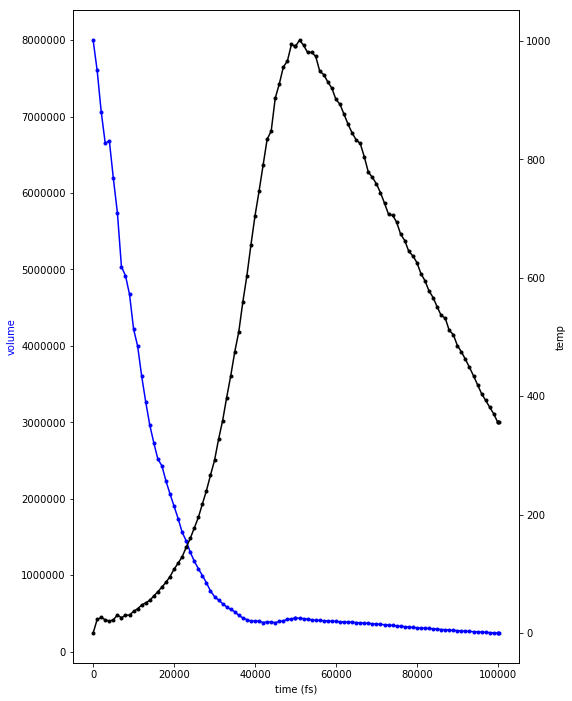

In [316]:
plot_mdrun(lmp_i)

Cool the volume is decreasing 

In [317]:
lmp_i.store()

In [318]:
lmp_i.pull()

Read in data file output and update positions

In [319]:
os.chdir(lmp_i.dir['launch'])

In [320]:
datafn = lmp_i.files['output']['data_3']
print datafn

equ0.data


In [321]:
lmp_i.read_data_pos(datafn)

In [322]:
print lmp_i.strucC.lat.matrix

[[ 62.34228115   0.           0.        ]
 [  0.          62.34228115   0.        ]
 [  0.           0.          62.34228115]]


In [323]:
lmp_i.strucC.tag += '_equ0'

In [324]:
lmp_i.strucC.write_xyz()

In [325]:
lmp_i.strucC.calc_center_mass()

In [326]:
struc_i = lmp_i.strucC

Let us create a new project to hold all the ET calculations we need to do for each pair of groups

In [327]:
mol_et_equ0 = streamm.Project('mol_et_equ0')

In [328]:
mol_et_equ0.set_resource(res_local)

In [329]:
os.chdir(mol_et_equ0.dir['materials'])

In [330]:
struc_json = struc_i.export_json()

If we need to restart the project here all we have to do is load in the structure 

In [331]:
# Restarting project here
struc_i = streamm.Buildingblock('p3HTx50_equ0')
struc_i.import_json()

In [332]:
struc_i.write_xyz('t1.xyz')

Create groups out of the molecules

In [333]:
groupset_i = streamm.Groups('mol',struc_i)

In [334]:
groupset_i.group_prop('mol','oligomers')

In [335]:
print len(groupset_i.groups)

50


In [336]:
groupset_i.strucC.lat.pbcs = [True,True,True]

In [337]:
print groupset_i.strucC.lat.pbcs

[True, True, True]


In [338]:
print groupset_i.strucC.lat.matrix

[[ 62.34228115   0.           0.        ]
 [  0.          62.34228115   0.        ]
 [  0.           0.          62.34228115]]


Apply periodic boundries to all the groups, so the molecules are not split across pbc's

In [339]:
groupset_i.group_pbcs()

In [340]:
groupset_i.strucC.write_xyz('groups.xyz')

In [341]:
groupset_i.calc_cent_mass()
groupset_i.calc_radius()
# groupset_i.calc_dl()

In [342]:
print groupset_i.strucC.lat
print len(groupset_i.cent_mass)
print len(groupset_i.radius)

62.342281 0.000000 0.000000
0.000000 62.342281 0.000000
0.000000 0.000000 62.342281
50
50


Save the structure we are creating our pairs from 

In [343]:
gmol_json = groupset_i.strucC.export_json()

Create a neighbor list of groups 

In [344]:
groupset_i.group_nblist.radii_nblist(groupset_i.strucC.lat,groupset_i.cent_mass,groupset_i.radius,radii_buffer=0.500)

In [345]:
print groupset_i.group_nblist

 NBlist of 50 particle with 142 connections


In [346]:
g_nbs = []
for gk_i,g_i in groupset_i.groups.iteritems():
        n_nbs = groupset_i.group_nblist.calc_nnab(gk_i)
        g_nbs.append(n_nbs)
g_nbs = np.array(g_nbs)    

In [347]:
print g_nbs.min(),g_nbs.mean(),g_nbs.max()

0 2.84 6


Loop over each group, shift the group to the center of the simulation cell and write an .xyz file that includes the neighbors of the group.

In [348]:
for gk_i,g_i in groupset_i.groups.iteritems():
        list_i = copy.deepcopy(g_i.pkeys)
        for g_j in groupset_i.group_nblist.getnbs(gk_i):
            list_i += groupset_i.groups[g_j].pkeys
        print gk_i,groupset_i.group_nblist.calc_nnab(gk_i),len(list_i)
        groupset_i.strucC.shift_pos(-1.0*g_i.cent_mass)  # Place center of mass at origin
        groupset_i.strucC.write_xyz_list(list_i,xyz_file='nn_{}.xyz'.format(gk_i))
        groupset_i.strucC.shift_pos(g_i.cent_mass)  # Return center of mass 
        
        del list_i

0 6 889
1 5 762
2 3 508
3 2 381
4 2 381
5 4 635
6 2 381
7 3 508
8 2 381
9 2 381
10 4 635
11 1 254
12 4 635
13 1 254
14 6 889
15 4 635
16 2 381
17 3 508
18 2 381
19 2 381
20 1 254
21 0 127
22 3 508
23 3 508
24 4 635
25 1 254
26 3 508
27 0 127
28 2 381
29 3 508
30 1 254
31 1 254
32 3 508
33 2 381
34 4 635
35 2 381
36 5 762
37 3 508
38 3 508
39 2 381
40 3 508
41 2 381
42 2 381
43 4 635
44 5 762
45 4 635
46 5 762
47 3 508
48 3 508
49 5 762


The nearest neighbor cluster look good so let us calculate the electron transfer 

Firts create a list of unique pairs 

In [349]:
g_pairs = []
for gk_i,g_i in groupset_i.groups.iteritems():
    for gk_j in groupset_i.group_nblist.getnbs(gk_i):
        if( gk_j > gk_i ):
            g_pairs.append([gk_i,gk_j])

In [350]:
print len(g_pairs)

71


Save that in a local file 

In [351]:
eout = open('g_pairs.csv','wb') 
ewriter = csv.writer(eout,delimiter=',')
ewriter.writerow( ["gk_i","gk_j"] )
for plist in g_pairs:
    ewriter.writerow( [plist[0],plist[1]] )
eout.close()

In [359]:
def nw_et(project_i,res_i,groupset_i,gk_i,gk_j):

    calc_n =  len(project_i.calculations)     
    nwchem_et = streamm.NWChem('nw_et_{}_g{}_g{}'.format(project_i.tag,gk_i,gk_j))
    print(nwchem_et.tag)

    # Set calculation to run on external resource
    nwchem_et.set_resource(res_i)

    # Make the local directories 
    nwchem_et.make_dir()
    # Change to the `launch` directory
    os.chdir(nwchem_et.dir['launch'])

    group_i = groupset_i.groups[gk_i]
    group_j = groupset_i.groups[gk_j]    

    nwchem_et.properties['coord_i'] = group_i.write_coord()
    nwchem_et.properties['coord_j'] = group_j.write_coord()    
    nwchem_et.properties['coord_ij'] = nwchem_et.properties['coord_i'] + nwchem_et.properties['coord_j'] 
    
    

    nwchem_et.cp_file('templates','run',"nwchem_peregrine.pbs",'templates','launch')
    nwchem_et.cp_file('templates','nw',"nwchem_et.nw",'templates','launch')
    #
    nwchem_et.load_str('templates','nw')        
    nwchem_et.load_str('templates','run')
    # 
    nwchem_et.replacewrite_prop('nw','input','nw','%s.nw'%(nwchem_et.tag))

    nwchem_et.properties['input_nw'] = nwchem_et.files['input']['nw']
    nwchem_et.replacewrite_prop('run','scripts','run','%s.pbs'%(nwchem_et.tag))

    nwchem_et.add_file('output','log',"%s.log"%(nwchem_et.tag))
    # Save details in .json files 
    # 
    os.chdir(nwchem_et.dir['home'])
    nwchem_et.export_json()
    # 
    os.chdir(nwchem_et.dir['launch'])
    nwchem_et.push()
    nwchem_et.run()
    ## Add calculation to project
    project_i.add_calc(nwchem_et,deepcopy = True)

    return project_i


Loop over all the pairs and create NWChem ET input files

In [360]:
for plist in g_pairs:
    gk_i = plist[0]
    gk_j = plist[1]
    mol_et_equ0 = nw_et(mol_et_equ0,peregrine,groupset_i,gk_i,gk_j)

nw_et_mol_et_equ0_g0_g3
nw_et_mol_et_equ0_g0_g14
nw_et_mol_et_equ0_g0_g15
nw_et_mol_et_equ0_g0_g19
nw_et_mol_et_equ0_g0_g43
nw_et_mol_et_equ0_g0_g49
nw_et_mol_et_equ0_g1_g16
nw_et_mol_et_equ0_g1_g17
nw_et_mol_et_equ0_g1_g28
nw_et_mol_et_equ0_g1_g33
nw_et_mol_et_equ0_g1_g44
nw_et_mol_et_equ0_g2_g31
nw_et_mol_et_equ0_g2_g32
nw_et_mol_et_equ0_g2_g47
nw_et_mol_et_equ0_g3_g38
nw_et_mol_et_equ0_g4_g12
nw_et_mol_et_equ0_g4_g39
nw_et_mol_et_equ0_g5_g24
nw_et_mol_et_equ0_g5_g42
nw_et_mol_et_equ0_g5_g44
nw_et_mol_et_equ0_g5_g46
nw_et_mol_et_equ0_g6_g35
nw_et_mol_et_equ0_g6_g47
nw_et_mol_et_equ0_g7_g11
nw_et_mol_et_equ0_g7_g26
nw_et_mol_et_equ0_g7_g40
nw_et_mol_et_equ0_g8_g38
nw_et_mol_et_equ0_g8_g46
nw_et_mol_et_equ0_g9_g23
nw_et_mol_et_equ0_g9_g34
nw_et_mol_et_equ0_g10_g28
nw_et_mol_et_equ0_g10_g36
nw_et_mol_et_equ0_g10_g37
nw_et_mol_et_equ0_g10_g49
nw_et_mol_et_equ0_g12_g18
nw_et_mol_et_equ0_g12_g22
nw_et_mol_et_equ0_g12_g29
nw_et_mol_et_equ0_g13_g26
nw_et_mol_et_equ0_g14_g32
nw_et_mol_et_equ0

In [358]:
    mol_et_equ0.check()

Sweet as bro!